In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy
import matplotlib.pyplot as plt
import utils.dlc_practical_prologue as prologue

import multiprocessing

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


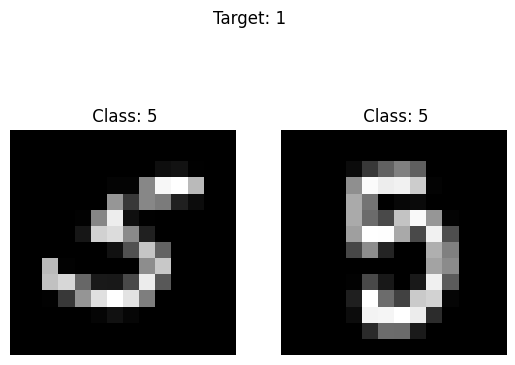

Train input shapetorch.Size([1000, 2, 14, 14])
Train target shapetorch.Size([1000])
Train classes shapetorch.Size([1000, 2])
---
Test input shape torch.Size([1000, 2, 14, 14])
Test target shape torch.Size([1000])
Test classes shape torch.Size([1000, 2])


In [35]:
from torch.utils.data import Dataset

from torch.utils.data import TensorDataset

BATCH_SIZE = 50

transform = transforms.Compose(
    [
        # transforms.ToTensor(),
        transforms.Lambda(lambda x: x.div(255))]
)

train_input, train_target, train_classes,\
    test_input, test_target, test_classes = prologue.generate_pair_sets(
        1000, transform=transform)
    
# train_input = transform(train_input)
# test_input = transform(test_input)

trainset = TensorDataset(train_input, train_target, train_classes)
testset = TensorDataset(test_input, test_target, test_classes)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers= 1)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers= 1)

# target: 1 if digit 1 <= digit 2, 
#         0 otherwise

# Plotting the first 5 pairs of images
for i in range(1):
    for j in range(2):
        plt.subplot(1, 2, j+1)
        plt.imshow(train_input[i, j].view(14, 14), cmap='gray')
        # plot the target and its class in the title
        plt.suptitle(f"Target: {train_target[i]}")
        plt.title(f' Class: {train_classes[i, j]}')
        plt.axis('off')
    plt.show()

# print the shapes of the tensors
print(f"Train input shape{train_input.shape}")
print(f"Train target shape{train_target.shape}")
print(f"Train classes shape{train_classes.shape}")
print('---')
print(f"Test input shape {test_input.shape}")
print(f"Test target shape {test_target.shape}")
print(f"Test classes shape {test_classes.shape}")


## Examine data format and normalize

In [36]:
print(train_input[0,1].shape)
print(train_input[0,1].dtype)
print(train_input[0,1].max())
print(train_input[0,1].min())

torch.Size([14, 14])
torch.float32
tensor(0.9922)
tensor(0.)


### Baseline

In [37]:
print(torch.mean(train_target.float()))
print(torch.mean(test_target.float()))

tensor(0.5530)
tensor(0.5600)


In [38]:
baseline_target_pred = torch.ones_like(train_target)

# compute accuracy of the baseline and the test target
acc = 100 * (baseline_target_pred == test_target).sum().item() / test_target.shape[0]
print(f"Baseline accuracy: {acc:.2f}%")

Baseline accuracy: 56.00%


### Convnet

TODO now:

1. figure out parameters for cnn layers

    a. Figure out input (w/ 2 images)
    
    b. Debug conv and pool parameters

2. Optimizer

In [39]:
torch.cuda.is_available()

False

In [40]:
class Net(nn.Module):
   def __init__(self):
      super().__init__()
      
      self.conv1 = nn.Conv2d(1, 16, 3)
      self.pool1 = nn.MaxPool2d(2)
      self.conv2 = nn.Conv2d(16, 32, 3)
      self.conv3 = nn.Conv2d(32, 64, 3)
      
      self.fc1 = nn.Linear(64*2*2*2, 80)
      self.fc1_aux = nn.Linear(64*2*2, 80)
      self.fc2 = nn.Linear(80, 40)
      
      self.fc3 = nn.Linear(40, 1) # for target prediction
      self.fc4 = nn.Linear(40,10) # for auxilary loss
      
      
      
   def forward(self, data):
      x = torch.narrow(data,dim=1,start=0,length=1)
      y = torch.narrow(data,dim=1,start=1,length=1)
      
      
      x = self.pool1(F.relu(self.conv1(x)))
      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x) )
      x = x.view(x.size(0), -1)

      
      y = self.pool1(F.relu(self.conv1(y)))
      y = F.relu(self.conv2(y))
      y = F.relu(self.conv3(y))
      y = y.view(y.size(0), -1)
      
      z = torch.cat((x,y), 1)
      
      z = F.relu(self.fc1(z))
      z = F.relu(self.fc2(z))
      res = torch.sigmoid(self.fc3(z))
      
      # embedded_images = torch.softmax(self.fc4(z), dim = 1)
      # return embedded_images,res

      emb_x = torch.softmax(F.relu(self.fc4(z)), dim = 1)
      emb_y = torch.softmax(F.relu(self.fc4(z)), dim = 1)
      return emb_x, emb_y, res
      
      
   
net = Net()

In [41]:
import torch.optim as optim

criterion = nn.BCELoss()
aux_criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.5)
optimizer = optim.Adam(net.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net.to(device)

cpu


Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=80, bias=True)
  (fc1_aux): Linear(in_features=256, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=1, bias=True)
  (fc4): Linear(in_features=40, out_features=10, bias=True)
)

In [42]:
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        ## -- ! code required  
        
        inputs, labels,classes = data

        inputs, labels, classes = inputs.to(device), labels.to(device), classes.to(device)
        
        optimizer.zero_grad()   # zero the gradient buffers
        output_x,output_y,output_z = net(inputs)
                
         # TODO : COMPUTE LOSS
        loss_x = aux_criterion(output_x, classes[:,0])
        loss_y = aux_criterion(output_y, classes[:,1])
        loss_z = criterion(output_z, labels.reshape(-1,1).type_as(output_z[:,:10]))
        loss = loss_x + loss_y + loss_z
        
        loss.backward()
        optimizer.step()


        # print statistics
        running_loss += loss.item()
        if i % 10 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % 
                (epoch + 1, i + 1, running_loss / (1000/trainloader.batch_size)), end='\r')
            running_loss = 0.0

print('Finished Training')

Finished Training 2.128


In [43]:
def test_accuracy(net, testloader):

    acc = 0
    for i, data in enumerate(testloader, 0):
        
        inputs, labels, classes = data

        # Concatenate both images side-by-side
        # left, right = inputs[:, 0], inputs[:, 1]
        # inputs = torch.cat((left, right), 2)
        # inputs = torch.unsqueeze(inputs, 1)
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        inputs, labels, classes = inputs.to(device), labels.to(device), classes.to(device)
    
        _,_,output_z = net(inputs)
        equality = (labels.reshape(-1, 1) == output_z.round().to(torch.int))
        acc += equality.to(torch.float).mean()

    return acc.item() / (i+1)

acc = test_accuracy(net, testloader)
print(f'Accuracy of the network on the {(i+1)*testloader.batch_size} test images: {100*acc:.1f} %')

Accuracy of the network on the 1000 test images: 86.5 %


In [44]:
from torchsummary import summary
model_view = Net()
summary(model_view,(2,14,14))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 12, 12]          160
├─MaxPool2d: 1-2                         [-1, 16, 6, 6]            --
├─Conv2d: 1-3                            [-1, 32, 4, 4]            4,640
├─Conv2d: 1-4                            [-1, 64, 2, 2]            18,496
├─Conv2d: 1-5                            [-1, 16, 12, 12]          (recursive)
├─MaxPool2d: 1-6                         [-1, 16, 6, 6]            --
├─Conv2d: 1-7                            [-1, 32, 4, 4]            (recursive)
├─Conv2d: 1-8                            [-1, 64, 2, 2]            (recursive)
├─Linear: 1-9                            [-1, 80]                  41,040
├─Linear: 1-10                           [-1, 40]                  3,240
├─Linear: 1-11                           [-1, 1]                   41
├─Linear: 1-12                           [-1, 10]                  410
├─Linear: 1-13                           [

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 12, 12]          160
├─MaxPool2d: 1-2                         [-1, 16, 6, 6]            --
├─Conv2d: 1-3                            [-1, 32, 4, 4]            4,640
├─Conv2d: 1-4                            [-1, 64, 2, 2]            18,496
├─Conv2d: 1-5                            [-1, 16, 12, 12]          (recursive)
├─MaxPool2d: 1-6                         [-1, 16, 6, 6]            --
├─Conv2d: 1-7                            [-1, 32, 4, 4]            (recursive)
├─Conv2d: 1-8                            [-1, 64, 2, 2]            (recursive)
├─Linear: 1-9                            [-1, 80]                  41,040
├─Linear: 1-10                           [-1, 40]                  3,240
├─Linear: 1-11                           [-1, 1]                   41
├─Linear: 1-12                           [-1, 10]                  410
├─Linear: 1-13                           [

### model saving

In [45]:
# save model parameters
torch.save(net.state_dict(), './Models/cnn_aux_loss.pt')

In [46]:
# load model parameters
model1 = Net()
model1.load_state_dict(torch.load('./Models/cnn_aux_loss.pt'))
model1.eval()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=80, bias=True)
  (fc1_aux): Linear(in_features=256, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=1, bias=True)
  (fc4): Linear(in_features=40, out_features=10, bias=True)
)